# Spotify Music Recommendation System

We draw inspiration from Spotify's "Discover Weekly" service and aim to recommend a list of songs to each user according to his preference.

The environment and the agents remain the same as shown in the notebook "Spotify Recommendation (Large dataset)".

Here, we try on a smaller dataset by the condition "user_id<=200".

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
import random
from scipy.stats import norm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import tensorflow as tf

## Import Data 

In [3]:
df = pd.read_csv("smaller_songs_dataset.csv")
df.head()

,user_id,item_id,listening_time_in_scale_0-5,title,duration,loudness,tempo,key,event_type
0,196,242,4.06,Atmosphere Station,191.81669,-38.525,90.084,9,"""Listen it frequently""""View Song Information""""..."
1,63,242,3.24,Atmosphere Station,191.81669,-38.525,90.084,9,"""Listen it frequently""""Like""""View Song Informa..."
2,154,242,4.34,Atmosphere Station,191.81669,-38.525,90.084,9,"""Listen it frequently""""Like""""View Song Informa..."
3,34,242,3.57,Atmosphere Station,191.81669,-38.525,90.084,9,"""Have listened it completely""""View Song Infor..."
4,35,242,3.09,Atmosphere Station,191.81669,-38.525,90.084,9,"""Have listened it completely""""View Song Infor..."


In [4]:
df['event_type'].value_counts()

"Listen it frequently""Download"                                                               286
"Have listened  it completely""Like""View Song Information""Download"                          283
"Listen it frequently""Add it to your music"                                                   282
"Have listened  it completely""View Song Information""Add it to your music"                    279
"Skip it""Not recommend it anymore"                                                            278
"Listen it frequently""Like""View Song Information"                                            275
"Have listened  it completely""Download"                                                       273
"Skip it frequently""Not recommend it anymore"                                                 273
"Listen it frequently""Like""Download"                                                         272
"Have listened  it completely""Like""Add it to your music"                                     270
"Have list

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9409 entries, 0 to 9408
Data columns (total 9 columns):
user_id                        9409 non-null int64
item_id                        9409 non-null int64
listening_time_in_scale_0-5    9409 non-null float64
title                          9409 non-null object
duration                       9409 non-null float64
loudness                       9409 non-null float64
tempo                          9409 non-null float64
key                            9409 non-null int64
event_type                     9409 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 661.6+ KB


In [6]:
max_user_id = df['user_id'].max()
max_item_id = df['item_id'].max()

print('max_user_id=%d, max_item_id=%d' % (max_user_id, max_item_id))

max_user_id=200, max_item_id=300


In [7]:
df['item_id'].value_counts()

50     118
258    116
100    105
294    102
286    100
181     98
288     96
7       94
121     94
1       90
56      86
300     85
174     83
127     83
237     81
222     80
98      80
79      75
25      72
269     72
117     71
172     70
276     69
15      67
9       67
69      66
151     65
118     64
204     64
173     63
      ... 
41       7
103      7
85       7
18       6
149      6
279      6
263      5
112      5
16       5
206      5
138      5
46       4
256      4
130      4
253      4
267      3
35       3
34       3
84       3
115      3
104      2
37       2
36       2
247      2
113      2
146      2
296      2
74       1
75       1
119      1
Name: item_id, Length: 300, dtype: int64

In [8]:
df['user_id'].value_counts()

1      272
13     191
92     181
94     160
59     159
7      153
130    145
178    140
194    139
95     129
18     127
62     123
151    119
85     119
109    118
43     115
64     114
145    113
90     111
184    110
144    107
6      106
198    103
158    102
56     102
102     99
44      98
87      98
200     98
49      97
      ... 
129     10
171     10
4       10
78      10
34       9
146      9
107      9
105      9
86       9
9        9
47       8
149      8
170      8
112      8
35       8
134      8
33       8
39       7
191      7
140      7
155      6
179      6
172      6
143      6
166      6
61       6
147      5
111      5
36       5
88       3
Name: user_id, Length: 200, dtype: int64

## Data Preprocessing 

Define strength for each event in 'event_type'

Quantify implicit event feedback 

In [9]:
# event --> strength
event_type_strength = {
    'Listen it frequently': 3.0,
    'Have listened  it completely': 1.0,
    'Like': 1.0,
    'View Song Information': 1.0,
    'Download': 3.0,
    'Add it to your music': 2.0,
    'Skip it':  -1.0, 
    'Skip it frequently': -3.0,
    'Not recommend it anymore': -2.0}

In [10]:
# extract event into a list from a string
df['event_type'] = df['event_type'].apply(lambda x: [e for e in x.split("\"") if len(e)])

# add a column event_strength
df['event_strength'] = df['event_type'].apply(lambda x: np.sum([event_type_strength[e] for e in x]))

In [11]:
# stats on event strength
df['event_strength'].value_counts()

 6.0     1328
 4.0     1323
 5.0     1322
 7.0     1313
 3.0      787
 8.0      743
-3.0      526
 9.0      521
 2.0      501
-5.0      273
-1.0      265
 1.0      257
 10.0     250
Name: event_strength, dtype: int64

In [12]:
df.head()

,user_id,item_id,listening_time_in_scale_0-5,title,duration,loudness,tempo,key,event_type,event_strength
0,196,242,4.06,Atmosphere Station,191.81669,-38.525,90.084,9,"[Listen it frequently, View Song Information, ...",7.0
1,63,242,3.24,Atmosphere Station,191.81669,-38.525,90.084,9,"[Listen it frequently, Like, View Song Informa...",5.0
2,154,242,4.34,Atmosphere Station,191.81669,-38.525,90.084,9,"[Listen it frequently, Like, View Song Informa...",7.0
3,34,242,3.57,Atmosphere Station,191.81669,-38.525,90.084,9,"[Have listened it completely, View Song Infor...",5.0
4,35,242,3.09,Atmosphere Station,191.81669,-38.525,90.084,9,"[Have listened it completely, View Song Infor...",4.0


## Environment

In [13]:
def random_argmax(rng, list_):
    """ return a random element among max when multiple max exists."""
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

In [14]:
np.set_printoptions(precision=2)

In [15]:
class music_rec_env:
    """ A rating environment that simulates Spotify.
        User and items are represented by points in R^3 modelling song style (loudness, tempo, key) 
        User interest for a given item is modeled by 3 parts:
        1. dot product of user,item embedding vector (cosine similarity, style coherence)
        2. user listening time estimation
        3. user event estimation (event_strength)
        action: Recommend a song list for a given user among those he has never listened to before
    """
    
    def __init__(self, data, seed=None,
                 internal_embedding_size=3,
                 displayed_users_embedding_size=2,
                 displayed_items_embedding_size=2,
                 noise_size=2):
        self.raw_data = data  # pandas dataframe with 'user_id', 'item_id' columns
        self.nb_users = len(df['user_id'].value_counts())
        self.nb_items = len(df['item_id'].value_counts())
        self.internal_embedding_size = internal_embedding_size
        self.displayed_users_embedding_size = displayed_users_embedding_size
        self.displayed_items_embedding_size = displayed_items_embedding_size
        self.noise_size = noise_size
        self._rng = np.random.RandomState(seed)
        
        self.action_size = self.nb_items
        self.sampling_limit = self.nb_users * self.nb_items
        self.users_embedding = None
        self.items_embedding = None
        self.user_item_history = None
        self.done = False

    def step(self, action_list):
        # check if behind done
        if self.done:
            print("Calling step after it returns done=True.\n"
                  "Please reset the environment.")

        # compute potential rewards
        potential_rewards = [self._get_user_item_rating(self.current_user, i) 
                             for i in np.argwhere(self.user_item_history[self.current_user, :] == 0).flatten()]
        
        # compute optimal reward
        optimal_returns = np.array(sorted(potential_rewards, reverse = True))[:len(action_list)]

        # map actions to items
        self.recommended_items = [np.argwhere(self.user_item_history[self.current_user, :] == 0)[action][0] for action in action_list]
        
        # mark items as rated
        self.user_item_history[self.current_user, self.recommended_items] = 1

        # compute reward R_t
        self.current_ratings = [self._get_user_item_rating(self.current_user, rec_item) for rec_item in self.recommended_items]
        self.rewards = self.current_ratings
        
        # check if done
        if self.user_item_history.sum() == self.sampling_limit:
            self.done = True

        # compute next state S_{t+1}
        self._next_state()

        # update action space t+1
        self.action_size = len(self.available_items)

        return self.rewards, self.state, self.done, optimal_returns

    def reset(self, data=None, seed=None):
        
        if data:
            self.raw_data = data
            
        if seed:
            self._rng = np.random.RandomState(seed)
 
        # create item embedding matrix (song style features) 
        song_df = self.raw_data[['item_id','loudness','tempo','key']].drop_duplicates().sort_values(by = 'item_id')
        style_raw_data = np.vstack((song_df['loudness'], song_df['tempo'],song_df['key'])).T
        min_max_scaler = MinMaxScaler()
        self.items_embedding = min_max_scaler.fit_transform(style_raw_data)
        
        # create user embedding matrix (song style preference features)
        self.users_embedding = np.array([])
        for user in np.array(sorted(self.raw_data['user_id'].unique())):
            user_raw_data = self.raw_data[self.raw_data['user_id']==user]
            tmp = user_raw_data[['loudness','tempo','key']].mul(user_raw_data['listening_time_in_scale_0-5'], axis=0)
            tmp = tmp.div(user_raw_data['listening_time_in_scale_0-5'].sum())
            user_unscaled_data = np.array(tmp.mean(axis=0))
            self.users_embedding = np.append(self.users_embedding, user_unscaled_data)    
        self.users_embedding = min_max_scaler.fit_transform(self.users_embedding.reshape(self.raw_data['user_id'].nunique(),3))    

        # initialize history matrix, recommend history + listening history
        # listening/reocmmend history = 1
        self.user_item_history = np.zeros((self.nb_users, self.nb_items))
        v_func = np.vectorize(self._get_listening_history)
        v_func(a=np.array(self.raw_data['user_id']), b=np.array(self.raw_data['item_id']))
        
        self.done = False

        self._next_state()
        return self.state
     
    def _get_listening_history(self, a, b):
        # record listening history in raw_data
        # a: user_id, b: item_id, M: ndarray
        self.user_item_history[a-1,b-1] = 1  # both id start from 1

    def _get_user_item_rating(self, user, item): 
        # score = style_matching_score + estimated_time_bonus + estimated_event_bonus
        # all 3 parts range from 0 to 1

        # compute style_matching_score
        style_matching_score = self.users_embedding[user].dot(self.items_embedding[item])
        
        user_raw_data = self.raw_data[self.raw_data['user_id']==user]
        songs_similarity = self.items_embedding[np.array(user_raw_data['item_id'])-1,:].dot(self.items_embedding[item])
        
        # compute estimated_time_bonus   
        unscaled_estimated_time_bonuses = user_raw_data['listening_time_in_scale_0-5'].mul(songs_similarity)
        scaled_estimated_time_bonuses = unscaled_estimated_time_bonuses.div(np.sum(songs_similarity))
        estimated_time_bonus = (scaled_estimated_time_bonuses.sum() - user_raw_data['listening_time_in_scale_0-5'].min())/ \
                               (user_raw_data['listening_time_in_scale_0-5'].max() - user_raw_data['listening_time_in_scale_0-5'].min())
        
        # compute estimated_event_bonus
        unscaled_estimated_event_bonuses = user_raw_data['event_strength'].mul(songs_similarity)
        scaled_estimated_event_bonuses = unscaled_estimated_event_bonuses.div(np.sum(songs_similarity))
        estimated_event_bonus = (scaled_estimated_event_bonuses.sum() - user_raw_data['event_strength'].min())/ \
                                (user_raw_data['event_strength'].max() - user_raw_data['event_strength'].min())
        
        score = style_matching_score + estimated_time_bonus + estimated_event_bonus
        return score

    def _get_variables(self, user, item):
        user_embedding = self.users_embedding[user]
        item_embedding = self.items_embedding[item]
        if self.displayed_users_embedding_size + self.displayed_items_embedding_size > 0:
            variables = np.array([user_embedding[:self.displayed_users_embedding_size],
                                  item_embedding[:self.displayed_items_embedding_size]])

            if self.noise_size > 0:
                noise = self._rng.normal(loc=np.zeros(self.noise_size),
                                         scale=np.ones(self.noise_size)/2,
                                         size=self.noise_size)
                variables = np.append(variables, noise)

            return variables

    def _get_new_user(self):
        has_picked = False
        user = self._rng.randint(0, self.nb_users)
        # get a new user who hasn't tried all the songs
        while np.sum(self.user_item_history[user, :]) == self.nb_items:
            user = self._rng.randint(0, self.nb_users)
        return user    

    def _next_state(self):
        # Pick a user
        if self.user_item_history.sum() < self.sampling_limit: 
            self.current_user = self._get_new_user()
        else:
            self.current_user = None

        # list available items
        self.available_items = np.argwhere(self.user_item_history[self.current_user, :] == 0)

        self.state = list()
        for i in self.available_items:
            item = i[0]   
            # compute variables (part of the user, item embedding (with noise))
            variables = self._get_variables(self.current_user, item)
            self.state.append([self.current_user+1, item+1, variables])


In [16]:
env =  music_rec_env(data = df, seed = 2020)

In [17]:
env.reset(seed=2020)[:10]  # user, available_item, user_item_feature with noise

[[97, 2, array([ 0.94,  0.04,  0.79,  0.41,  0.18, -0.51])],
 [97, 3, array([ 0.94,  0.04,  0.8 ,  0.49,  0.05, -0.61])],
 [97, 4, array([ 0.94,  0.04,  0.93,  0.54,  0.99, -0.04])],
 [97, 5, array([ 0.94,  0.04,  0.8 ,  0.61, -0.42,  0.09])],
 [97, 6, array([ 0.94,  0.04,  0.58,  0.46, -0.13,  0.91])],
 [97, 8, array([ 0.94,  0.04,  0.68,  0.36, -0.2 , -0.01])],
 [97, 9, array([ 0.94,  0.04,  0.87,  0.47,  0.03, -1.32])],
 [97, 10, array([ 0.94,  0.04,  0.78,  0.61, -0.62, -0.79])],
 [97, 11, array([ 0.94,  0.04,  0.84,  0.49, -0.15, -0.56])],
 [97, 12, array([ 0.94,  0.04,  0.87,  0.54,  0.4 , -0.29])]]

In [18]:
np.array(sorted(df[df['user_id']==97]['item_id']))[:10]

array([ 1,  7, 23, 28, 32, 50, 69, 79, 82, 83])

User 865 is connecting to the platform.

Recommend him three songs among all available songs.

For each user-item pair, observe also a vector of features that depends on the user, the song and/or some context(like occasion, weather, user's emotion, etc).

In [19]:
reward, next_state, done, optimal_return = env.step(np.arange(3)) # pick the first 3 available items in the list 
print('reward: ', reward)
print('best reward:',optimal_return)

reward:  [2.002575394346569, 2.0178195138700845, 2.136511046242062]
best reward: [2.21 2.2  2.2 ]


In [22]:
next_state[:10]

[[8, 1, array([ 0.95,  0.05,  0.78,  0.5 , -0.25, -0.23])],
 [8, 2, array([ 0.95,  0.05,  0.79,  0.41, -0.02, -0.27])],
 [8, 3, array([ 0.95,  0.05,  0.8 ,  0.49,  0.59, -0.96])],
 [8, 4, array([ 0.95,  0.05,  0.93,  0.54, -0.27,  0.34])],
 [8, 5, array([ 0.95,  0.05,  0.8 ,  0.61, -0.77,  0.56])],
 [8, 6, array([ 0.95,  0.05,  0.58,  0.46,  0.14, -0.34])],
 [8, 8, array([ 0.95,  0.05,  0.68,  0.36, -0.65,  0.7 ])],
 [8, 9, array([ 0.95,  0.05,  0.87,  0.47, -0.04,  0.52])],
 [8, 10, array([ 0.95,  0.05,  0.78,  0.61,  0.53, -0.3 ])],
 [8, 12, array([ 0.95,  0.05,  0.87,  0.54,  0.63, -0.64])]]

In [23]:
np.array(sorted(df[df['user_id']==57]['item_id']))[:10]

array([ 1,  7,  8, 11, 15, 24, 28, 42, 50, 56])

In [24]:
env.reset(seed=2000)[:10]
reward, next_state, done, optimal_return = env.step(np.arange(3)) # pick the first 3 available items in the list 
print('reward: ', reward)
print('best reward:',optimal_return)

reward:  [1.7945825118311647, 1.8011543134940111, 1.7997561397450048]
best reward: [2.01 2.   1.99]


## Agent

## Random Agent

In [25]:
class Random:
    """ Random agent. """
    def __init__(self, nb_arms, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        
    def act(self, context):
        actions = self._rng.randint(len(context), size = self._nb_arms)  
        #actions = self._rng.randint(np.array(context).shape[1], size = self._nb_arms)  
        return actions
    
    def update(self, context, actions, rewards):
        pass
        

##  UCB Agent

In [27]:
class UCB:
    """ Upper Confidence Bound agent. """

    def __init__(self, nb_arms, n_user, n_item, c=2., seed=None):
        self._nb_arms = nb_arms
        self._n_user = n_user
        self._n_item = n_item
        self._c = c
        self._rng = np.random.RandomState(seed)
        #self._q = np.zeros(nb_arms)
        self._q = np.zeros((self._n_user, self._n_item))
        self._n = np.zeros((self._n_user, self._n_item))
        self._t = 0
        
    def act(self, context):
        user = context[0][0]  # current user id
        
        if 0 in self._n:
            actions = self._rng.choice(np.where(self._n==0)[1], self._nb_arms) #(nb_arms,)
        
        else:
            actions = [self._q[user, i] / self._n[user, i] + self._c*np.sqrt(np.log(self._t)/self._n[user, i]) 
                       for i in range(self._n_item)]
       
            actions = np.array(actions) #(n_item,)
            actions = actions.argsort()[-self._nb_arms:][::-1]  #(nb_arm,), select the top nb_arms recommended songs and return their item_id
        
        return actions

    
    def update(self, context, actions_chosen, reward_list):
        last_user = context[0][0]
        for i, a in enumerate(actions_chosen):
            self._n[last_user, a] += 1
            self._q[last_user, a] += reward_list[i]
        self._t += 1
       
        last_reco_items = np.array([context[a][1] for a in actions_chosen])
        
        

## Linear UCB Agent

In [28]:
class LinUCB:
   
    def __init__(self, nb_arms, n_user, n_item, c=2., seed=None, delta =0.1,alpha=0.1,lmbda=1,S=1 ):
        self._nb_arms = nb_arms
        self._n_user = n_user
        self._n_item = n_item
        self._c = c
        self._rng = np.random.RandomState(seed)
        #self._q = np.zeros(nb_arms)
        self._q = np.zeros((self._n_user, self._n_item))
        self._n = np.zeros((self._n_user, self._n_item))
        self._t = 0
        self._delta = delta
        self._alpha = alpha
        self._lmbda = lmbda
        self._S = S
        self._b = np.zeros(self._n_item) #(n_item,) 
        self._A_a = np.eye(self._n_item) #(n_item,n_item)
        self._A_a_inv = np.linalg.inv(self._A_a) # inverse of covariance matrix #(n_item,n_item)
      
 
    def init(self):

        self._t = 0
        #self.theta = np.zeros(self.d) 
        self._theta = np.zeros(self._n_item) #(n_item,)

        
    def act(self, context):
        user = context[0][0]  # current user id
        
        if 0 in self._n:
            actions = self._rng.choice(np.where(self._n==0)[1], self._nb_arms) #(nb_arms,)
            payoffs = self._rng.choice(np.where(self._n==0)[1], self._n_item) #(n_item,)
        
        else:
            actions = [self._q[user, i] / self._n[user, i] + self._c*np.sqrt(np.log(self._t)/self._n[user, i]) 
                       for i in range(self._n_item)]
       
            actions = np.array(actions) #(n_item,)
            #actions = actions.argsort()[-self._nb_arms:][::-1]  #(nb_arm,), select the top nb_arms recommended songs and return their item_id
            
            self.theta = self._A_a_inv @ self._b #(n_item,)
            beta = np.sqrt(self._lmbda)*self._S + np.sqrt(2*log(1/self._delta) + log(np.linalg.det(self._A_a) 
                                                                              / (self._lmbda**self._n_item)))
            
            payoffs =[np.dot(self._theta, action) + np.sqrt(beta * self._alpha) *(actions.T @ self._A_a_inv @ actions)
                       for action in actions]#(n_item,)
    
            actions = payoffs.argsort()[-self._nb_arms:][::-1]  #(nb_arm,), select the top nb_arms recommended songs and return their item_id
    
        return payoffs, actions

    def update(self, context, actions_chosen, pay_offs, reward_list):
        last_user = context[0][0]
        chosen_items = np.zeros(self._n_item)#(n_item,)
        for i, a in enumerate(actions_chosen):
            self._n[last_user, a] += 1
            self._q[last_user, a] += reward_list[i]
            chosen_items[a] == pay_offs[a]
        for i, a in enumerate(actions_chosen):
            self._b += chosen_items* reward_list[i]#(n_item,)

        self._t += 1
        self._A_a += np.outer(chosen_items, chosen_items) #(n_item,n_item)
        # Using Sherman–Morrison formula to compute the inverse of the sum of an invertible matrix A and the outer product
        self._A_a_inv -= (self._A_a_inv @ np.outer(chosen_items, chosen_items) @ self._A_a_inv)/(1 + chosen_items.T @ self._A_a_inv @ chosen_items)
        last_reco_items = np.array([context[a][1] for a in actions_chosen])
        

## Experiment

In [29]:
def run_exp(agent, env, nb_steps, nb_arms,env_seed):
    rewards_list = np.zeros((nb_steps, nb_arms))
    regrets_list = np.zeros((nb_steps, nb_arms))
    actions_list = np.zeros((nb_steps, nb_arms))
    context = env.reset(data = None, seed = env_seed)

    for i in range(nb_steps):
        # Select action from agent policy.
        
        actions = agent.act(context)
        
        # Play action in the environment and get reward.
        
        rewards, next_context, done, optimal_return = env.step(actions)
        
        # Update history
        user = context[0][0]
        #item = context[action][1]
        items = np.array([context[a][1] for a in actions], dtype = int)  # a list of [user_id, item_id, ]
        rating = rewards
        
        # Update agent.
        agent.update(context, actions, rewards)
        context = next_context
        
        # Save history.
        rewards_list[i] = rewards
        actions_list[i] = actions
        regrets_list[i] = optimal_return - rewards

    reward = np.sum(rewards_list, axis = 0)
    regret = np.sum(regrets_list, axis = 0)
 
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards_list,
            'regrets': regrets_list,
            'actions': actions_list,
            'cum_rewards': np.cumsum(rewards_list, axis = 0), 
            'cum_regrets': np.cumsum(regrets_list, axis = 0),
            }


## Results by using Random Agent

In [30]:
random_agent = Random(nb_arms = 3, seed=0)

In [31]:
res_random_agent = run_exp(random_agent, env, nb_steps=5, nb_arms=3, env_seed=0)

In [32]:
res_random_agent

{'reward': array([10.2 , 10.95, 10.61]),
 'regret': array([1.81, 1.03, 1.26]),
 'rewards': array([[1.86, 2.12, 2.32],
        [1.95, 2.27, 2.21],
        [2.46, 2.66, 2.02],
        [1.91, 1.83, 2.09],
        [2.02, 2.08, 1.97]]),
 'regrets': array([[0.56, 0.31, 0.11],
        [0.32, 0.  , 0.03],
        [0.54, 0.32, 0.9 ],
        [0.28, 0.35, 0.09],
        [0.11, 0.05, 0.14]]),
 'actions': array([[172.,  47., 117.],
        [192., 251., 195.],
        [  9., 211., 277.],
        [242.,  87.,  70.],
        [ 88., 140.,  58.]]),
 'cum_rewards': array([[ 1.86,  2.12,  2.32],
        [ 3.81,  4.39,  4.53],
        [ 6.27,  7.04,  6.55],
        [ 8.18,  8.87,  8.64],
        [10.2 , 10.95, 10.61]]),
 'cum_regrets': array([[0.56, 0.31, 0.11],
        [0.88, 0.31, 0.13],
        [1.42, 0.63, 1.03],
        [1.7 , 0.98, 1.12],
        [1.81, 1.03, 1.26]])}

## Draw empirical regret and confidence bound

In [52]:
def draw_regret_bound(agent_name, nb_arms=3, nb_exp=10, nb_steps=10):
    '''
    Repeat environment-agent interations and draw regret bound for a given agent
    '''    
    regret = np.zeros(nb_exp)
    regrets = np.zeros((nb_exp, nb_steps))
    for i in range(nb_exp):
        env = music_rec_env(data = df, seed = i)
        if agent_name == 'random':
            agent = Random(nb_arms, seed=i)
        if agent_name == 'ucb':
            agent = UCB(nb_arms, n_user=200, n_item=100, seed=i)
            
        exp = run_exp(agent, env, nb_steps, nb_arms, env_seed=2*i)
        
        regret[i] = np.sum(exp['regret'])
        regrets[i] = np.sum(exp['cum_regrets'], axis = 1) 
        
    plt.plot(regrets.mean(axis=0), color='blue')
    plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
    plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
    plt.title('Mean regret: {:.2f}'.format(regret.mean()))
    plt.xlabel('steps')
    plt.ylabel('regret')
    plt.show()   
    
    

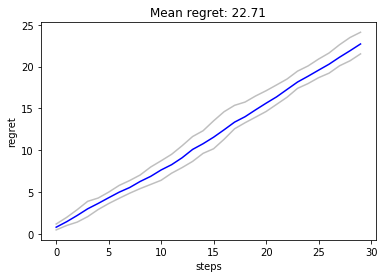

In [258]:
draw_regret_bound('random', nb_arms=3, nb_exp=10, nb_steps=30)


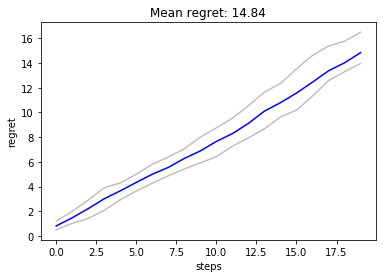

In [315]:
draw_regret_bound('random', nb_arms=3, nb_exp=10, nb_steps=20)


## Result by using UCB Agent

In [51]:
ucb = UCB(nb_arms = 3, n_user=200, n_item=100, seed=0)

In [39]:
res_ucb = run_exp(ucb, env, nb_steps=5, nb_arms=3, env_seed=0)

In [40]:
res_ucb

{'reward': array([10.51, 10.25, 10.23]),
 'regret': array([0.95, 1.17, 1.14]),
 'rewards': array([[2.09, 2.17, 2.07],
        [2.08, 2.1 , 2.02],
        [2.12, 1.99, 2.01],
        [2.05, 1.85, 1.98],
        [2.17, 2.15, 2.15]]),
 'regrets': array([[0.21, 0.13, 0.23],
        [0.36, 0.31, 0.35],
        [0.06, 0.19, 0.16],
        [0.13, 0.33, 0.19],
        [0.19, 0.21, 0.21]]),
 'actions': array([[32., 99., 45.],
        [51., 26., 28.],
        [22., 41., 36.],
        [41., 50., 61.],
        [62.,  1., 95.]]),
 'cum_rewards': array([[ 2.09,  2.17,  2.07],
        [ 4.17,  4.28,  4.09],
        [ 6.29,  6.26,  6.1 ],
        [ 8.34,  8.11,  8.08],
        [10.51, 10.25, 10.23]]),
 'cum_regrets': array([[0.21, 0.13, 0.23],
        [0.57, 0.44, 0.58],
        [0.63, 0.63, 0.74],
        [0.76, 0.96, 0.94],
        [0.95, 1.17, 1.14]])}

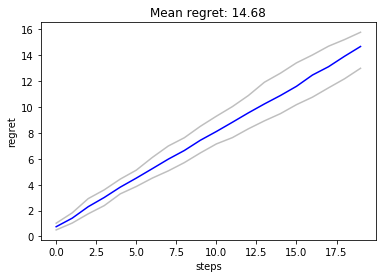

In [314]:
draw_regret_bound('ucb', nb_arms=3, nb_exp=10, nb_steps=20)


## Result by using Linear UCB Agent

In [316]:
linear_ucb = LinUCB(nb_arms=3, n_user=200, n_item=100, c=2., seed=None, delta =0.1,alpha=0.1,lmbda=1,S=1 )

In [317]:
def run_exp_linear_ucb(agent, env, nb_steps, nb_arms,env_seed):
    rewards_list = np.zeros((nb_steps, nb_arms))
    regrets_list = np.zeros((nb_steps, nb_arms))
    actions_list = np.zeros((nb_steps, nb_arms))
    context = env.reset(data = None, seed = env_seed)

    for i in range(nb_steps):
        # Select action from agent policy.
        payoffs, actions = agent.act(context)
        
        # Play action in the environment and get reward.
        rewards, next_context, done, optimal_return = env.step(actions)
        
        # Update history
        user = context[0][0]
        #item = context[action][1]
        items = np.array([context[a][1] for a in actions])  # a list of [user_id, item_id, ]
        rating = rewards
        
        # Update agent.
        agent.update(context, actions, payoffs, rewards)
        context = next_context
        
        # Save history.
        rewards_list[i] = rewards
        actions_list[i] = actions
        regrets_list[i] = optimal_return - rewards

    reward = np.sum(rewards_list, axis = 0)
    regret = np.sum(regrets_list, axis = 0)
 
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards_list,
            'regrets': regrets_list,
            'actions': actions_list,
            'cum_rewards': np.cumsum(rewards_list, axis = 0), 
            'cum_regrets': np.cumsum(regrets_list, axis = 0),
            }



In [318]:
res_linear_ucb = run_exp_linear_ucb(linear_ucb, env, nb_steps=5, nb_arms=3, env_seed=0)

In [319]:
res_linear_ucb

{'reward': array([ 9.82, 10.47, 10.08]),
 'regret': array([1.66, 0.9 , 1.12]),
 'rewards': array([[1.85, 2.18, 2.1 ],
        [1.92, 2.12, 2.03],
        [2.01, 2.11, 1.9 ],
        [2.16, 2.12, 2.18],
        [1.88, 1.95, 1.87]]),
 'regrets': array([[0.48, 0.14, 0.17],
        [0.28, 0.07, 0.14],
        [0.26, 0.13, 0.31],
        [0.34, 0.33, 0.22],
        [0.3 , 0.24, 0.28]]),
 'actions': array([[28., 58., 16.],
        [30., 48., 96.],
        [46., 24., 88.],
        [66., 16., 39.],
        [49., 64., 34.]]),
 'cum_rewards': array([[ 1.85,  2.18,  2.1 ],
        [ 3.77,  4.3 ,  4.13],
        [ 5.78,  6.41,  6.03],
        [ 7.94,  8.52,  8.21],
        [ 9.82, 10.47, 10.08]]),
 'cum_regrets': array([[0.48, 0.14, 0.17],
        [0.75, 0.21, 0.31],
        [1.02, 0.34, 0.62],
        [1.36, 0.66, 0.85],
        [1.66, 0.9 , 1.12]])}

In [320]:
def draw_regret_bound_linear_ucb(nb_arms, nb_exp, nb_steps):
    '''
    Repeat environment-agent interations and draw regret bound for a given agent
    '''    
    regret = np.zeros(nb_exp)
    regrets = np.zeros((nb_exp, nb_steps))
    for i in range(nb_exp):
        env = music_rec_env(data = df, seed = i)
        agent = LinUCB(nb_arms=3, n_user=200, n_item=100, c=2., seed=None, delta =0.1,alpha=0.1,lmbda=1,S=1 )
        exp = run_exp_linear_ucb(agent, env, nb_steps, nb_arms, env_seed=2*i)
        
        regret[i] = np.sum(exp['regret'])
        regrets[i] = np.sum(exp['cum_regrets'], axis = 1) 
        
    plt.plot(regrets.mean(axis=0), color='blue')
    plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
    plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
    plt.title('Mean regret: {:.2f}'.format(regret.mean()))
    plt.xlabel('steps')
    plt.ylabel('regret')
    plt.show()   
    
    

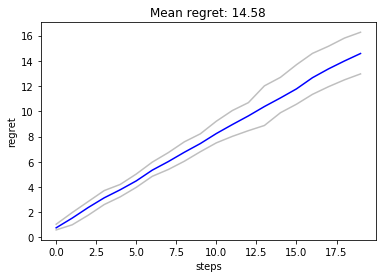

In [322]:
draw_regret_bound_linear_ucb(nb_arms=3, nb_exp=10, nb_steps=20)
